In [1]:
from conf import databases, url, data_dir
from file_utils import create_folder
from dnn_helper import *

import numpy
import random
import time

import lasagne
from matplotlib import pyplot as plt
import matplotlib as mpl

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1050 Ti (0000:01:00.0)


In [2]:
fs = 128
trained_fs = 360
min_bpm = 10
max_bpm = 350
min_gap = fs*60/min_bpm
max_gap = fs*60/max_bpm

# NN params
segment_size = 5000
segment_step = 2500
y_delay = 0

train_perc = 90
test_perc = 100 - train_perc

# Border suppression for evaluation
left_border  = 50 # samples
right_border = 50 # samples

trainXY, testXY = load_db('ltdb', y_delay=y_delay, segment_size=segment_size segment_step=segment_step, train_perc=train_perc)
unique_items, counts = numpy.unique(trainXY[:,1], return_counts=True)
ratio_zero_one = counts[0]/counts[1]
print('- {:.0f} times more 1s than 0s'.format(ratio_zero_one))

Loaded 27168 examples of length 5000 with a delay of 0 sample(s).
- 24451 training examples (90%)
- 2717 testing examples (10%)
- 100 times more 1s than 0s


In [3]:
model_path = 'saved-models/0.035'
create_folder(model_path)

In [4]:
from theano import tensor, function, config
from theano.tensor import basic, clip
from lasagne.updates import adam, nesterov_momentum
from lasagne.layers import InputLayer, DenseLayer, Conv1DLayer, BiasLayer,\
                           get_output, get_all_params, set_all_param_values,\
                           get_output_shape, ConcatLayer,get_all_param_values
from lasagne.nonlinearities import sigmoid, rectify
from lasagne.init import GlorotUniform
from theano.printing import Print
from lasagne.regularization import regularize_network_params, l2, l1

def get_batch_gen(XY, batchsize, shuffle=False):
    X, Y, N = XY[:,0], XY[:,1], XY.shape[0]
    if shuffle:
        indices = numpy.arange(len(X))
        numpy.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield sa(X[excerpt], 1, 2), sa(Y[excerpt], 1, 2)

def get_batch(XY, batchsize, shuffle):
    for x, y in get_batch_gen(XY, batchsize, shuffle=shuffle):
        return x, y

def my_loss(model, predictions, targets, regularization):
    predictions = predictions[0][0][left_border:-right_border]
    targets = targets[0][left_border:-right_border]
    loss = tensor.abs_(tensor.log((targets * predictions).sum() / targets.sum())) +\
           tensor.abs_(tensor.log(((1-targets) * (1-predictions)).sum() / (1-targets).sum()))
    reg_loss = regularize_network_params(model, l1) * 1e-4
    if regularization:
        return loss + reg_loss
    else:
        return loss

In [5]:
class NN:
    def __init__(self, model_builder, dim):
        self.t_in = tensor.ftensor3('inputs')  #  =X     float64
        self.t_out = tensor.imatrix('targets') # =Y_true int32
        self.input_shape = (None, dim, segment_size,)
        self.output_shape  = (None, dim, segment_size,)
        self.model = model_builder(self.t_in, dim=dim, shape=self.input_shape)
        self.init_funs(self.model)
    
    def init_funs(self, model):        
        test_pred = get_output(self.model, deterministic=True)
        test_loss = my_loss(self.model, test_pred, self.t_out, False)
        test_loss_with_reg = my_loss(self.model, test_pred, self.t_out, True)
        test_acc  = tensor.mean(tensor.eq(tensor.argmax(test_pred, axis=1), self.t_out), dtype=config.floatX)

        self.eval_fn  = function([self.t_in, self.t_out], [test_loss, test_loss_with_reg, test_acc], allow_input_downcast=True)
        self.evaluate = function([self.t_in], get_output(self.model, self.t_in), allow_input_downcast=True)
        
    def train(self, trainXY, testXY, batch_size, num_epochs, examples_by_epoch, stop_accuracy=100.0, info=False):
        trainN, testN = trainXY.shape[0], testXY.shape[0]
        print('Training on {} examples, testing on {} examples.'.format(trainN, testN))
        print("Starting training...")
        
        pred = get_output(self.model)
        loss = my_loss(self.model, pred, self.t_out, True)
        params = get_all_params(self.model, trainable=True)
        updates = adam(loss, params=params, learning_rate=0.0001)
        train_fn = function([self.t_in, self.t_out], loss, updates=updates, allow_input_downcast=True)
        
        examples_used = 0
        train_losses = []
        rps = []
        for epoch in range(1, num_epochs+1):
            start_time = time.time()
            print('Epoch {}/{} running...'.format(epoch, num_epochs), end='')
            train_loss = 0
            xs, ys = get_batch(trainXY, examples_by_epoch, shuffle=True)
            for z in range(examples_by_epoch):
                x, y = numpy.asarray([xs[z]]), ys[z]
#                 print(x.shape, y.shape)
                train_loss += train_fn(x, y)
                train_losses.append(train_loss/(z+1))
                examples_used += 1
            print('Done in {:.3f}s!'.format(time.time() - start_time))
            print("  - training loss:\t\t{:.6f}".format(train_loss / examples_by_epoch))
            
            # Eval on examples:
            test_loss = 0
            test_reg_loss = 0
            test_acc = 0
            for k in range(testN):
                x, y = testXY[k,0], testXY[k,1]
#                 print(x.shape, y.shape)
                tmp_loss, tmp_reg_loss, tmp_acc = self.eval_fn(numpy.asarray([sa(x, 0, 1)]), sa(y, 0, 1))
                test_loss += tmp_loss
                test_reg_loss += (tmp_reg_loss-tmp_loss)
                test_acc  += tmp_acc
            print("  - test loss:\t\t\t{:.6f} | {:.6f} | {:.6f}".format(test_loss / testN, test_reg_loss / testN, (test_loss+test_reg_loss) / testN))
            acc = test_acc / testN * 100
            print("  - test accuracy:\t\t{:.4f} %".format(acc))
            plt.plot(train_losses, color='r')
            plt.plot(rps, color='g')
            plt.show()
            eval_model(testXY, self.evaluate, min_gap=min_gap, max_gap=max_gap, plot_examples=True, nb=3, nearest_fpr=0.01, threshold=0.95)
            save_model(model_path + '/model-loss{}-epoch{}.sav'.format(test_loss / testN, epoch), self.model, get_all_param_values(self.model))
            if acc > stop_accuracy:
                break

In [6]:
def build_model(input_tensor, dim, shape=None):
    print('Model shape:')
    
    l_in = InputLayer(shape, input_var=input_tensor)
    
    print('  Layer A:')
    a1 = Conv1DLayer(l_in, num_filters=8, filter_size=(3), nonlinearity=rectify, pad='same')
    print('    a1:', get_output_shape(a1))
    a2 = Conv1DLayer(l_in, num_filters=64, filter_size=(15), nonlinearity=rectify, pad='same')
    print('    a2:', get_output_shape(a2))
    a3 = Conv1DLayer(l_in, num_filters=64, filter_size=(45), nonlinearity=rectify, pad='same')
    print('    a3:', get_output_shape(a3))
    a4 = Conv1DLayer(l_in, num_filters=32, filter_size=(89), nonlinearity=rectify, pad='same')
    print('    a4:', get_output_shape(a4))
    a5 = Conv1DLayer(l_in, num_filters=16, filter_size=(149), nonlinearity=rectify, pad='same')
    print('    a5:', get_output_shape(a5))
    a6 = Conv1DLayer(l_in, num_filters=16, filter_size=(199), nonlinearity=rectify, pad='same')
    print('    a6:', get_output_shape(a6))
    a7 = Conv1DLayer(l_in, num_filters=16, filter_size=(299), nonlinearity=rectify, pad='same')
    print('    a7:', get_output_shape(a7))
    al = ConcatLayer([a1, a2, a3, a4, a5, a6, a7], axis=1)
    print('   al:', get_output_shape(al))
    
    print('  Layer B:')
    b1 = Conv1DLayer(al, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    b1:', get_output_shape(b1))
    b2 = Conv1DLayer(al, num_filters=64, filter_size=9, nonlinearity=rectify, pad='same')
    print('    b2:', get_output_shape(b2))
    b3 = Conv1DLayer(al, num_filters=64, filter_size=19, nonlinearity=rectify, pad='same')
    print('    b3:', get_output_shape(b3))
    b4 = Conv1DLayer(al, num_filters=64, filter_size=39, nonlinearity=rectify, pad='same')
    print('    b4:', get_output_shape(b4))
    bl = ConcatLayer([b1, b2, b3], axis=1)
    print('   bl:', get_output_shape(bl))

    print('  Layer C:')
    c1 = Conv1DLayer(bl, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    c1:', get_output_shape(c1))
    c2 = Conv1DLayer(bl, num_filters=32, filter_size=5, nonlinearity=rectify, pad='same')
    print('    c2:', get_output_shape(c2))
    c3 = Conv1DLayer(bl, num_filters=32, filter_size=9, nonlinearity=rectify, pad='same')
    print('    c3:', get_output_shape(c3))
    c4 = Conv1DLayer(bl, num_filters=32, filter_size=15, nonlinearity=rectify, pad='same')
    print('    c4:', get_output_shape(c4))
    c5 = Conv1DLayer(bl, num_filters=32, filter_size=19, nonlinearity=rectify, pad='same')
    print('    c5:', get_output_shape(c5))
    cl = ConcatLayer([c1, c2, c3, c4, c5])
    print('   cl:', get_output_shape(cl))
    
    print('  Layer D:')
    d1 = Conv1DLayer(cl, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    d1:', get_output_shape(d1))
    d2 = Conv1DLayer(cl, num_filters=32, filter_size=5, nonlinearity=rectify, pad='same')
    print('    d2:', get_output_shape(d2))
    d3 = Conv1DLayer(cl, num_filters=64, filter_size=15, nonlinearity=rectify, pad='same')
    print('    d3:', get_output_shape(d3))
    dl = ConcatLayer([d1, d2, d3])
    print('   dl:', get_output_shape(dl))
    
    print('  Later E:')
    e1 = Conv1DLayer(dl, num_filters=16, filter_size=5, nonlinearity=rectify, pad='same')
    print('    e1:', get_output_shape(e1))
    e2 = Conv1DLayer(dl, num_filters=16, filter_size=15, nonlinearity=rectify, pad='same')
    print('    e2:', get_output_shape(e2))
    e3 = Conv1DLayer(dl, num_filters=16, filter_size=19, nonlinearity=rectify, pad='same')
    print('    e3:', get_output_shape(e3))
    el = ConcatLayer([e1, e2, e3])
    print('   el:', get_output_shape(el))
    
    print('  Layer F:')
    f1 = Conv1DLayer(el, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    f1:', get_output_shape(f1))
    f2 = Conv1DLayer(el, num_filters=16, filter_size=9, nonlinearity=rectify, pad='same')
    print('    f2:', get_output_shape(f2))
    f3 = Conv1DLayer(el, num_filters=16, filter_size=15, nonlinearity=rectify, pad='same')
    print('    f3:', get_output_shape(f3))
    fl = ConcatLayer([f1, f2, f3])
    print('   fl:', get_output_shape(fl))
    
    print('  Layer G:')
    g1 = Conv1DLayer(fl, num_filters=1, filter_size=3, nonlinearity=sigmoid, pad='same')
    print('    g1:', get_output_shape(g1))
    gl = ConcatLayer([g1])
    print('   gl:', get_output_shape(gl))
    
    return gl


nn = NN(dim=1, model_builder=build_model)

Model shape:
  Layer A:
    a1: (None, 8, 5000)
    a2: (None, 64, 5000)
    a3: (None, 64, 5000)
    a4: (None, 32, 5000)
    a5: (None, 16, 5000)
    a6: (None, 16, 5000)
    a7: (None, 16, 5000)
   al: (None, 216, 5000)
  Layer B:
    b1: (None, 8, 5000)
    b2: (None, 64, 5000)
    b3: (None, 64, 5000)
    b4: (None, 64, 5000)
   bl: (None, 136, 5000)
  Layer C:
    c1: (None, 8, 5000)
    c2: (None, 32, 5000)
    c3: (None, 32, 5000)
    c4: (None, 32, 5000)
    c5: (None, 32, 5000)
   cl: (None, 136, 5000)
  Layer D:
    d1: (None, 8, 5000)
    d2: (None, 32, 5000)
    d3: (None, 64, 5000)
   dl: (None, 104, 5000)
  Later E:
    e1: (None, 16, 5000)
    e2: (None, 16, 5000)
    e3: (None, 16, 5000)
   el: (None, 48, 5000)
  Layer F:
    f1: (None, 8, 5000)
    f2: (None, 16, 5000)
    f3: (None, 16, 5000)
   fl: (None, 40, 5000)
  Layer G:
    g1: (None, 1, 5000)
   gl: (None, 1, 5000)


In [ ]:
nn.train(trainXY, testXY, batch_size=4, num_epochs=1200, examples_by_epoch=1000, info=True)

In [7]:
_, params = load_model(model_path + '/model-loss0.037631392673427445-epoch1200.sav')
# print(params)
set_all_param_values(nn.model, params)
nn.init_funs(nn.model)

Example 1615
Example 333
Example 1383
Example 628
Example 1712
Example 2458
Example 934
Example 2605
Example 1658
Example 1058


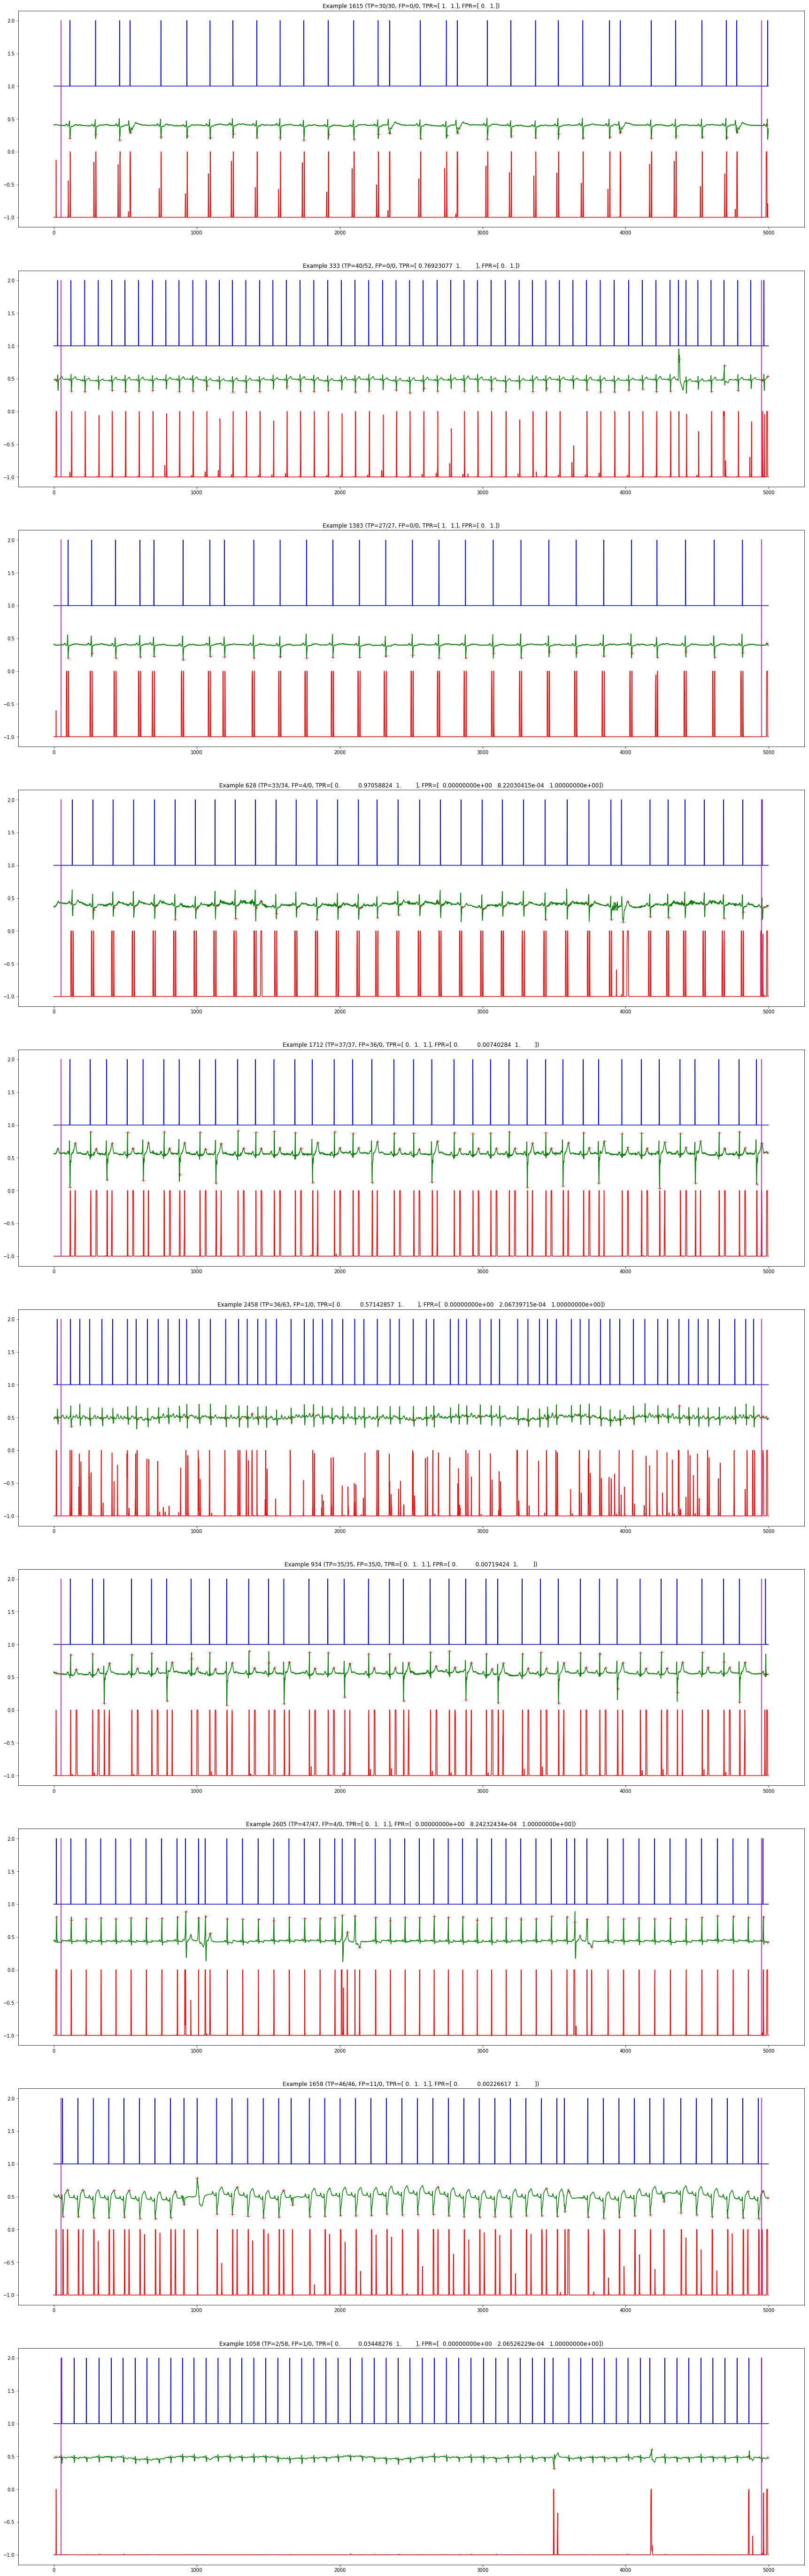

FPR			TPR			Threshold
0.000000		0.000000\+t	2.0000000


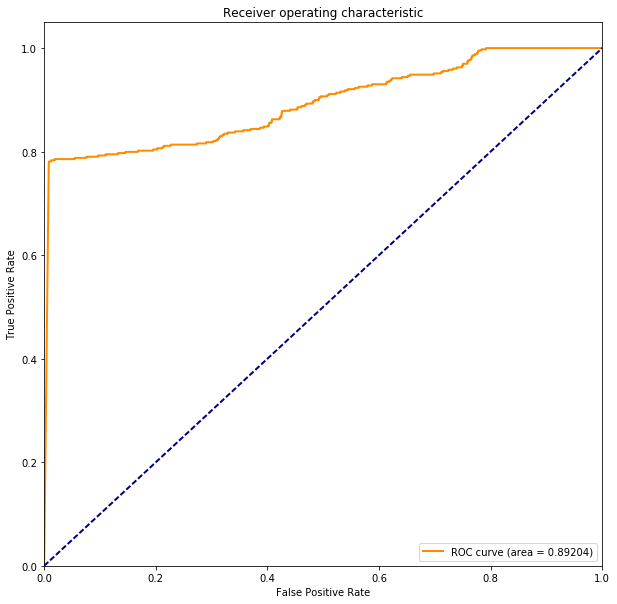

Samples:		49000 samples
Beats:
  - 429 labelized
  - 733 detected
  - TP:  335/429
  - FP:  398/0
  - TPR: 0.7809


In [8]:
eval_model(testXY, nn.evaluate, left_border=left_border, right_border=right_border,
           min_gap=min_gap, max_gap=max_gap, plot_examples=True, nb=10,
           nearest_fpr=0.000675, threshold=0.9678147, eval_margin=10)